In [40]:
import wandb
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
api = wandb.Api()
runs = api.runs("saleml/hvi_paper_final")

In [3]:
interesting_runs = []
for run in runs:
    interesting_runs.append(run)
    # run.file("model.pt").download(replace=True)

In [32]:
run.state

'finished'

In [58]:
groups = {}
for mode in ['tb', 'reverse_kl', 'rws', 'forward_kl', 'reverse_rws', 'modified_db']:
    for sampling_mode in ['on_policy', 'pure_off_policy']:
        for baseline in ['None', 'local', 'global']:
            for replay_capacity in [1000, 10000]:
                groups[f"{mode}_{sampling_mode}_{baseline}_{replay_capacity}"] = []
                for run in interesting_runs:
                    if run.state == 'finished':
                        if run.config['mode'] == mode and run.config['sampling_mode'] == sampling_mode and run.config['baseline'] == baseline and run.config['replay_capacity'] == replay_capacity:
                            groups[f"{mode}_{sampling_mode}_{baseline}_{replay_capacity}"].append(run.history())


In [90]:
for key in groups.keys():
    if len(groups[key]) == 0:
        del groups[key]

RuntimeError: dictionary changed size during iteration

In [59]:
def get_group_average(group, column_name):
    "takes a list of dataframes as input and returns a numpy array of the average of the column across the dataframes"
    return np.mean(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0), np.std(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0)

In [77]:
get_group_average(groups['tb_on_policy_None_1000'], 'jsd')

(array([       nan, 0.37582704, 0.30255364, 0.26041151, 0.25817322,
        0.2502205 , 0.2190235 , 0.21743041, 0.21559856, 0.21696554,
        0.21411363, 0.21725965, 0.25305521, 0.18755722, 0.16898772,
        0.15747288, 0.15834368, 0.14390125, 0.12286501, 0.11759759,
        0.10854513, 0.10686926, 0.10360396, 0.10261509, 0.10161972,
        0.10029749, 0.09347479, 0.07441415, 0.07085511, 0.06948352,
        0.06930947, 0.06881055, 0.06925987, 0.06913703, 0.06211541,
        0.05809935, 0.05014757, 0.0466555 , 0.04476176, 0.04368089,
        0.04272376, 0.03846756, 0.03602914, 0.02876281, 0.02832548,
        0.02525687, 0.02399081, 0.0229744 , 0.02247875, 0.02135911,
        0.01512576, 0.00678494, 0.00912463, 0.00239104, 0.00186733,
        0.00294634, 0.00200466, 0.00188004, 0.00164414, 0.00208378,
        0.00148275, 0.00159488, 0.00159139, 0.00128397, 0.00129879,
        0.00104835, 0.00100381, 0.00125302, 0.00099039, 0.00094542,
        0.00095941, 0.00097031, 0.00098696, 0.00

In [130]:
average_jsd = {}
std_jsd = {}
states_visited = {}
average_modes_found = {}
std_modes_found = {}
for key in groups.keys():
    if len(groups[key]) > 0:
        average_jsd[key] = get_group_average(groups[key], 'jsd')[0]
        std_jsd[key] = get_group_average(groups[key], 'jsd')[1]
        states_visited[key] = get_group_average(groups[key], 'states_visited')[0]
        average_modes_found[key] = get_group_average(groups[key], 'modes_found')[0]
        std_modes_found[key] = get_group_average(groups[key], 'modes_found')[1]



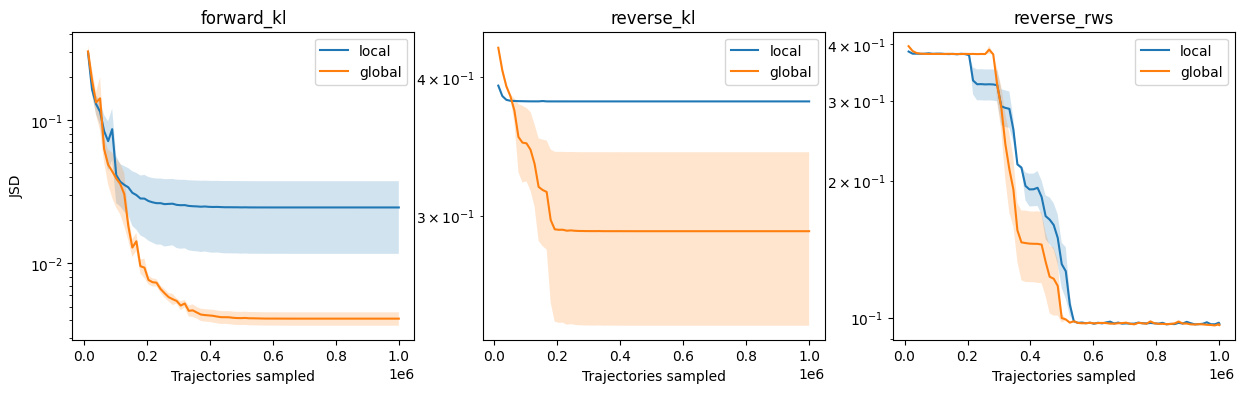

In [117]:
# Comparing the baseline for on-policy losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, mode in enumerate(['forward_kl', 'reverse_kl', 'reverse_rws']):
    for j, baseline in enumerate(['local', 'global']):
        group_name = f"{mode}_on_policy_{baseline}_1000"
        if group_name in average_jsd.keys():
            states_visited_j = states_visited[group_name]
            average_jsd_j = average_jsd[group_name]
            std_jsd_j = std_jsd[group_name]
            std_error_jsd_j = std_jsd_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_jsd_j, label=f"{baseline}")
            axes[i].fill_between(states_visited_j, average_jsd_j - std_error_jsd_j, average_jsd_j + std_error_jsd_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    axes[i].set_title(f"{mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.show()

In [125]:
better_keys = {'tb': 'Trajectory Balance (GFN)', 'modified_db': 'Modified DB (GFN)',
 'forward_kl': 'Forward KL', 'reverse_kl': 'Reverse KL', 'reverse_rws': 'Reverse RWS', 'rws': 'RWS'}

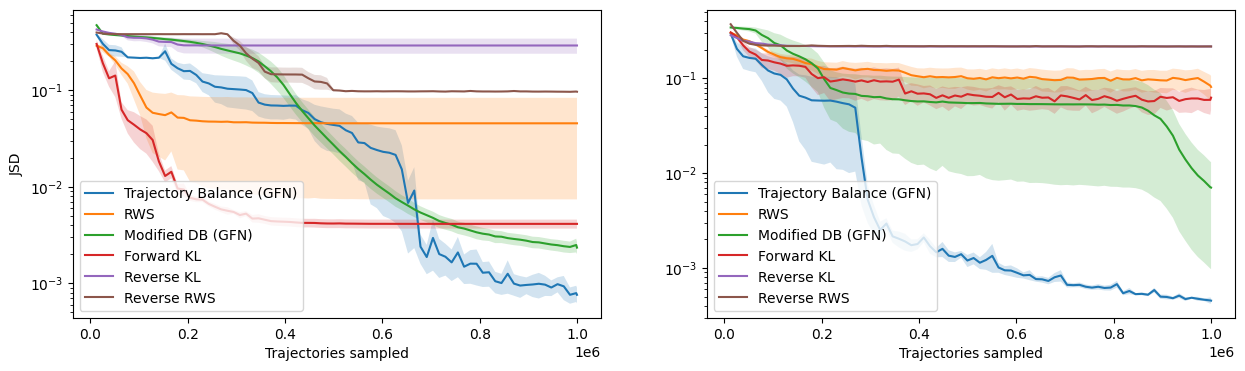

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i, sampling_mode in enumerate(['on_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'modified_db', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        baseline = 'global' if mode in ['forward_kl', 'reverse_kl', 'reverse_rws'] else 'None'
        group_name = f"{mode}_{sampling_mode}_{baseline}_1000"
        if group_name in average_jsd.keys():
            states_visited_j = states_visited[group_name]
            average_jsd_j = average_jsd[group_name]
            std_jsd_j = std_jsd[group_name]
            std_error_jsd_j = std_jsd_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_jsd_j, label=better_keys[mode])
            axes[i].fill_between(states_visited_j, average_jsd_j - std_error_jsd_j, average_jsd_j + std_error_jsd_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    # axes[i].set_title(f"{sampling_mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.show()

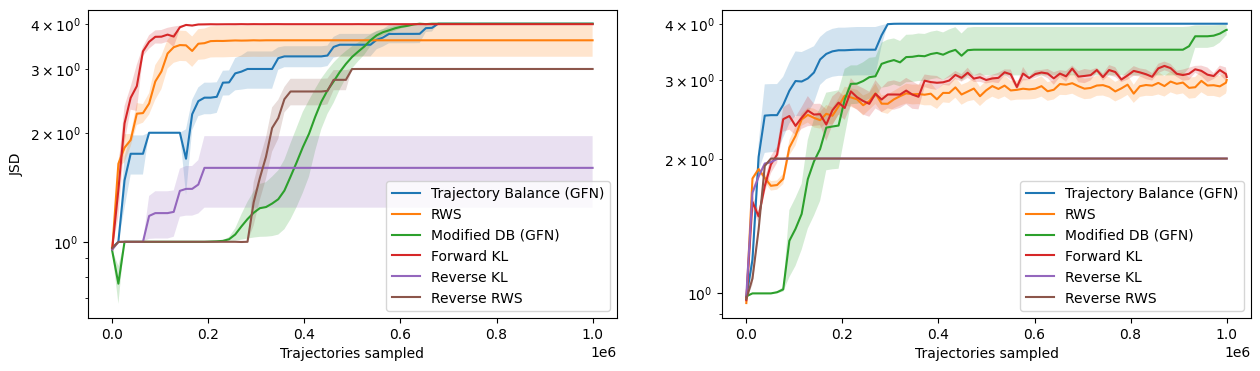

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i, sampling_mode in enumerate(['on_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'modified_db', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        baseline = 'global' if mode in ['forward_kl', 'reverse_kl', 'reverse_rws'] else 'None'
        group_name = f"{mode}_{sampling_mode}_{baseline}_1000"
        if group_name in average_modes_found.keys():
            states_visited_j = states_visited[group_name]
            average_modes_found_j = average_modes_found[group_name]
            std_modes_found_j = std_modes_found[group_name]
            std_error_modes_found_j = std_modes_found_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_modes_found_j, label=better_keys[mode])
            axes[i].fill_between(states_visited_j, average_modes_found_j - std_error_modes_found_j, average_modes_found_j + std_error_modes_found_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    # axes[i].set_title(f"{sampling_mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.show()

In [135]:
import os
for run in interesting_runs:
    if run.config['mode'] in ['reverse_kl', 'forward_kl', 'reverse_rws']:
        if run.config['baseline'] != 'global':
            continue
    if run.config['replay_capacity'] != 1000:
        continue
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    name = f"{run.config['mode']}_{run.config['sampling_mode']}_{run.config['baseline']}_{run.config['replay_capacity']}_{run.config['seed']}"
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            print(name, iteration, file.name)
            file.download(replace=True)
            file_directory = os.path.join(os.getcwd(), 'media', 'images')
            os.rename(file.name, os.path.join(file_directory, f"{name}.png"))



rws_pure_off_policy_None_1000_109 15624 media/images/P_T_15624_3aff1631b034b6fdd7c8.png
reverse_rws_on_policy_global_1000_109 15624 media/images/P_T_15624_68b763268ea5c78b87aa.png
reverse_rws_pure_off_policy_global_1000_109 15624 media/images/P_T_15624_9b70263fa6c93d0f907d.png
forward_kl_pure_off_policy_global_1000_109 15624 media/images/P_T_15624_ff1a7727b60ed55bffbc.png
forward_kl_on_policy_global_1000_109 15624 media/images/P_T_15624_fa0b692f7fea15a81bcd.png
rws_on_policy_None_1000_109 15624 media/images/P_T_15624_a97b1c5cd27a4028fda8.png
reverse_kl_pure_off_policy_global_1000_109 15624 media/images/P_T_15624_0b95c165d9cbe4769e9c.png
rws_pure_off_policy_None_1000_109 15624 media/images/P_T_15624_e692eeb89cecc527c521.png
reverse_kl_on_policy_global_1000_109 15624 media/images/P_T_15624_b5fa00d0b6b051f040b4.png
modified_db_on_policy_None_1000_109 15624 media/images/P_T_15624_b1bca146122d8a0d23c6.png
tb_pure_off_policy_None_1000_109 15624 media/images/P_T_15624_6509c769b8dc46b45c70.png

FileNotFoundError: [Errno 2] No such file or directory: 'media/images/final/target.png'

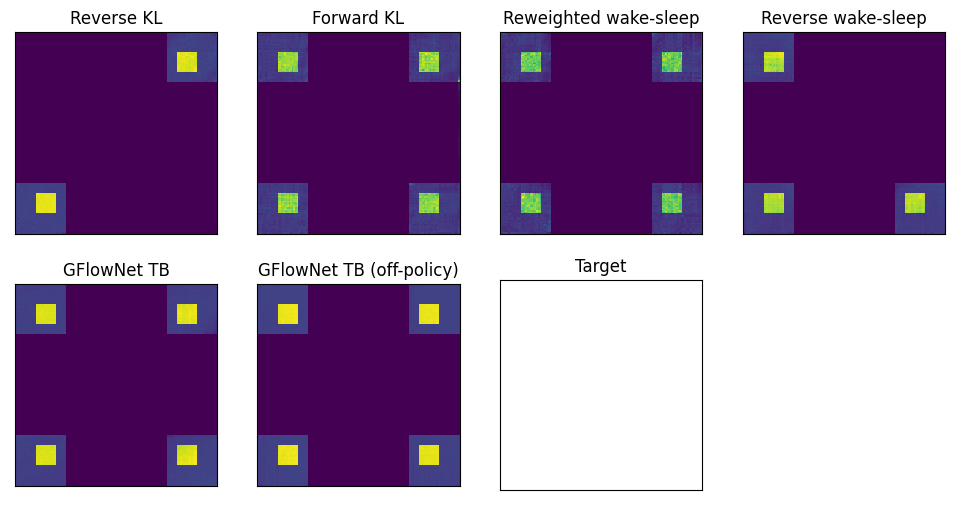

In [134]:
from PIL import Image
import os
import matplotlib

def filename_to_mode(filename):
    if 'forward_kl' in filename:
        return 'Forward KL'
    elif 'reverse_kl' in filename:
        return 'Reverse KL'
    elif 'reverse_rws' in filename:
        return 'Reverse RWS'
    elif 'modified_db' in filename:
        return 'Modified DB'
    elif 'tb' in filename:
        return 'Trajectory Balance'
    elif 'rws' in filename:
        return 'RWS'
    else:
        return 'Unknown'

def filename_to_sampling_mode(filename):
    if 'on_policy' in filename:
        return 'On-Policy'
    elif 'pure_off_policy' in filename:
        return 'Off-Policy'
    else:
        return 'Unknown'

files = os.listdir('media/images/all')
algs = [ f[:-4] for f in files ]
plt.figure(figsize=(12,6))
algos = {}
for image in files:
    key = filename_to_mode(image) + '_' + filename_to_sampling_mode(image)

for mode in ['tb', 'rws', 'modified_db', 'forward_kl', 'reverse_kl', 'reverse_rws']:
    for sampling_mode in ['on_policy', 'pure_off_policy']:
        

name2name = { 
              'on_policy_reverse_kl_final': "Reverse KL",
              'on_policy_forward_kl_final': "Forward KL", 
              'on_policy_rws_final': "Reweighted wake-sleep",
              'on_policy_reverse_rws_final': "Reverse wake-sleep",
              # 'on_policy_modified_db': "GFlowNet modified DB", 
              'on_policy_tb_final': "GFlowNet TB",
              'off_policy_tb_final': "GFlowNet TB (off-policy)",
              'target': "Target"}

for i,alg in enumerate(name2name):
    plt.subplot(2,4,i+1)
    plt.xticks([]);plt.yticks([])
    plt.title(name2name[alg])
    if i<7:
        img = np.array(Image.open(f'media/images/final/{alg}.png'))/255.
        g = img[62:445:3,66:449:3]
        c = np.array(matplotlib.cm.viridis.colors)
        v = ((g[...,:3,None]-c.T)**2).sum(-2).argmin(-1)
    else:
        v=truev
    plt.imshow(v[::-1], cmap='viridis', interpolation='none')
plt.savefig('grid-learned-dists.pdf')
plt.show()

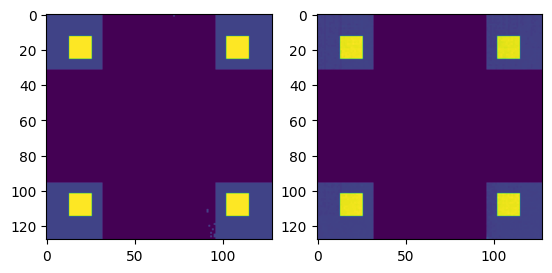

In [133]:
truev = np.copy(v)
truev[(truev>0)*(truev<100)] = 51
truev[truev>51]=255
plt.subplot(121)
plt.imshow(truev)
plt.subplot(122)
plt.imshow(v)
plt.show()

In [109]:
group_name = "reverse_kl_on_policy_local_1000"
std_jsd[group_name]

array([           nan, 1.14484218e-03, 1.44619898e-03, 2.71589560e-04,
       1.83616800e-04, 1.03495174e-04, 8.87694438e-05, 1.22497734e-04,
       6.13280633e-05, 4.12288753e-05, 3.16138147e-05, 3.30038975e-05,
       4.95229872e-04, 3.59884928e-05, 3.54706705e-05, 3.71276256e-05,
       3.44444644e-05, 3.54744393e-05, 3.44059653e-05, 3.49942235e-05,
       3.46072647e-05, 3.43289483e-05, 3.43962783e-05, 3.45049348e-05,
       3.45608557e-05, 3.45527699e-05, 3.45364557e-05, 3.45293499e-05,
       3.45434789e-05, 3.45323099e-05, 3.45416430e-05, 3.45494384e-05,
       3.45651523e-05, 3.45686560e-05, 3.45894715e-05, 3.45877768e-05,
       3.45691298e-05, 3.45789215e-05, 3.46052135e-05, 3.45844599e-05,
       3.45791424e-05, 3.46218339e-05, 3.46040585e-05, 3.46059537e-05,
       3.46064876e-05, 3.45830936e-05, 3.45959931e-05, 3.45980725e-05,
       3.46332192e-05, 3.46420657e-05, 3.46455739e-05, 3.46463656e-05,
       3.46319174e-05, 3.46712918e-05, 3.46638272e-05, 3.46593983e-05,
      

In [56]:
## OLD !!!!!!!

In [11]:
def rename_columns_and_concat(dfs, names, columns):
    for df, name in zip(dfs, names):
        df.columns = [name + '_' + col for col in columns]
    return pandas.concat(dfs, axis=1)

In [13]:
df = rename_columns_and_concat([run.history()[['states_visited', 'jsd', 'modes_found']] for run in interesting_runs],
 [run.name for run in interesting_runs],
  ['states_visited', 'jsd', 'modes_found'])

KeyboardInterrupt: 

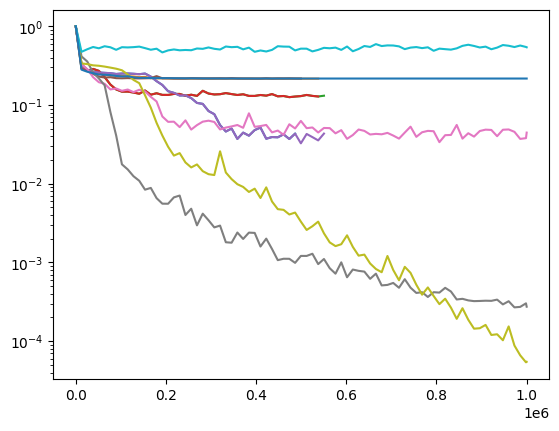

In [5]:
import matplotlib.pyplot as plt
for run in interesting_runs:
    plt.semilogy(run.history()['states_visited'], run.history()['jsd'].astype(float).fillna(1), label=run.name)
plt.legend()
# plt.savefig('JSD_vs_n_trajectories.png')

In [18]:
run.history()['jsd'].astype(float).fillna(1)

0     1.000000
1     0.306398
2     0.288680
3     0.245420
4     0.237580
        ...   
76    0.002435
77    0.002453
78    0.002447
79    0.002474
80    0.002434
Name: jsd, Length: 81, dtype: float64

In [22]:
df.to_csv('wandb_data_23-09-12-38.csv')

In [26]:
dir(run.files())

['QUERY',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_page',
 'client',
 'convert_objects',
 'cursor',
 'index',
 'last_response',
 'length',
 'more',
 'next',
 'objects',
 'per_page',
 'run',
 'update_variables',
 'variables']

In [54]:
run.files()[len(run.files()) - 4].name

'media/images/P_T_700_1f384fd85acb19a0306b.png'

In [55]:
len(run.history()['P_T'])

68

In [66]:
for run in interesting_runs:
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    print(run.name, iteration)
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            file.download(replace=True)

8000
10200
7400
6800
13200
10600
6700


In [67]:
for run in interesting_runs:
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    print(run.name, iteration)


best-on-policy-rws 8000
best-on-policy-forward-kl 10200
best-on-policy-reverse-rws 7400
best-on-policy-reverse-kl 6800
best-on-policy-tb 13200
best-on-policy-modified-db 10600
best-off-policy-tb 6700
